In [1]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
    'width': 1280,
    'height': 800,
    'scroll': True
})

{'width': 1280, 'height': 800, 'scroll': True}

## Setup

### Imports

In [4]:
from time import time
from collections import Counter
# from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt
from IPython.display import SVG, display

from scipy.spatial.distance import cdist
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing import sequence
from keras.callbacks import Callback, TensorBoard

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
from sklearn.decomposition import IncrementalPCA

### Settings

In [2]:
plt.style.use('ggplot')
pd.set_option('float_format', '{:,.2f}'.format)
%matplotlib inline
np.random.seed(42)

## TED2013 Corpus Statistics

In [5]:
with pd.HDFStore('vocab.h5') as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: vocab.h5
/ngrams            frame        (shape->[570,4])    
/stats             series       (shape->[3])        
/tokens            frame        (shape->[3224080,3])
/vocab             frame        (shape->[42276,1])  


In [6]:
with pd.HDFStore('vocab.h5') as store:
    df = store['vocab']

wc = df['count'].value_counts().sort_index(ascending=False).reset_index()
wc.columns = ['word_count', 'freq']
wc['n_words'] = wc.word_count.mul(wc.freq)

wc['corpus_share'] = wc.n_words.div(wc.n_words.sum())
wc['coverage'] = wc.corpus_share.cumsum()
wc['vocab_size'] = wc.freq.cumsum()

print('# words: {:,d}'.format(wc.n_words.sum()))
print(wc.loc[:, ['word_count', 'freq', 'n_words', 'vocab_size', 'coverage']].head(10))
print(wc.loc[:, ['word_count', 'freq', 'n_words', 'vocab_size', 'coverage']].tail(10))

# words: 2,917,337
   word_count  freq  n_words  vocab_size  coverage
0      151222     1   151222           1      0.05
1       98829     1    98829           2      0.09
2       79482     1    79482           3      0.11
3       61783     1    61783           4      0.13
4       53451     1    53451           5      0.15
5       51688     1    51688           6      0.17
6       51036     1    51036           7      0.19
7       43901     1    43901           8      0.20
8       39446     1    39446           9      0.22
9       38687     1    38687          10      0.23
      word_count   freq  n_words  vocab_size  coverage
1001          10    352     3520        6623      0.98
1002           9    383     3447        7006      0.98
1003           8    510     4080        7516      0.98
1004           7    619     4333        8135      0.98
1005           6    779     4674        8914      0.98
1006           5   1032     5160        9946      0.98
1007           4   1477     5908   

In [7]:
wc.word_count.div(wc.n_words.sum()).mul(100).describe(percentiles=[.5, .75, .95, .96, .97, .98, .99, .999])

count   1,011.00
mean        0.08
std         0.28
min         0.00
50%         0.02
75%         0.06
95%         0.32
96%         0.37
97%         0.49
98%         0.65
99%         1.11
99.9%       3.38
max         5.18
Name: word_count, dtype: float64

In [11]:
with pd.HDFStore('vocab.h5') as store:
    sentences = store['vocab'].index

In [12]:
model = Word2Vec(sentences, min_count=1)
# model.save('brown_model')
# print(' Brown corpus model saved.')

# model = Word2Vec.load('brown_model')

#words most similar to mother
print(model.wv.most_similar('computer'))

#find the odd one out
print(model.wv.doesnt_match('computer book library newspaper'.split()))

#vector representation of word human
print(model['computer'])

KeyError: "word 'computer' not in vocabulary"

## `word2vec` - skipgram Architecture using Keras

### Settings

In [17]:
NGRAMS = 3                                # Longest ngram in text
FILE_NAME = 'ngrams_{}'.format(NGRAMS)    # Input to use
MIN_FREQ = 5
SAMPLING_FACTOR = 1e-4
WINDOW_SIZE = 5
EMBEDDING_SIZE = 200
EPOCHS = 1
BATCH_SIZE = 50

# Set up validation
VALID_SET = 10      # Random set of words to get nearest neighbors for
VALID_WINDOW = 150  # Most frequent words to draw validation set from
NN = 10             # Number of nearest neighbors for evaluation

valid_examples = np.random.choice(VALID_WINDOW, size=VALID_SET, replace=False)

In [14]:
path = Path('keras', SOURCE, LANGUAGE, FILE_NAME).resolve()
tb_path = path / 'tensorboard'
if not tb_path.exists():
    tb_path.mkdir(parents=True, exist_ok=True)

### Build Data Set

#### Tokens to ID

1. Extract the top *n* most common words to learn embeddings
2. Index these *n* words with unique integers
3. Create an `{index: word}` dictionary
4. Replace the *n* words with their index, and a dummy value `UNK` elsewhere

In [15]:
def build_data(ngrams=1):
    file_path = 'ngrams_{}.txt'.format(ngrams)
    words = file_path.read_text().split()
    
    # Get (token, count) tuples for tokens meeting MIN_FREQ 
    token_counts = [t for t in Counter(words).most_common() if t[1] >= MIN_FREQ]
    tokens, counts = list(zip(*token_counts))
    
    # create id-token dicts & reverse dicts
    id_to_token = pd.Series(tokens, index=range(1, len(tokens) + 1)).to_dict()
    id_to_token.update({0: 'UNK'})
    token_to_id = {t:i for i, t in id_to_token.items()}
    data = [token_to_id.get(word, 0) for word in words]
    return data, token_to_id, id_to_token

In [18]:
data, token_to_id, id_to_token = build_data(ngrams=NGRAMS)

AttributeError: 'str' object has no attribute 'read_text'

In [16]:
vocab_size = len(token_to_id)

In [17]:
vocab_size

24038

In [18]:
min(data), max(data)

(0, 24037)

In [19]:
s = pd.Series(data).value_counts().reset_index()
s.columns = ['id', 'count']
s['token'] = s.id.map(id_to_token)

In [20]:
s.sort_values('count', ascending=False).head(10)

,id,count,token
0,1,255096,the
1,2,181404,and
2,3,148988,to
3,4,140548,of
4,5,128774,a
5,6,113156,that
6,7,99242,i
7,8,94808,in
8,9,93862,it
9,10,88098,you


In [21]:
s.sort_values('id').token.dropna().to_csv(tb_path / 'meta.tsv', index=False)

#### Analogies to ID

In [22]:
df = pd.read_csv(Path('data', 'analogies', 'analogies-{}.txt'.format(LANGUAGE)), 
                 header=None, squeeze=True)
categories = df[df.str.startswith(':')]
analogies = df[~df.str.startswith(':')].str.split(expand=True)
analogies.columns = list('abcd')

In [23]:
analogies.head()

,a,b,c,d
1,athens,greece,baghdad,iraq
2,athens,greece,bangkok,thailand
3,athens,greece,beijing,china
4,athens,greece,berlin,germany
5,athens,greece,bern,switzerland


In [24]:
analogies_id = analogies.apply(lambda x: x.map(token_to_id))
analogies_id.notnull().all(1).sum()/len(analogies_id)

0.40422180214240705

### Generate Sampling Probabilities

There is an alternative, faster scheme than the traditional SoftMax loss function called [Noise Contrastive Estimation (NCE)](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf).

Instead of getting the softmax probability for all possible context words, randomly sample 2-20 possible context words and evaluate the probability only for these.

**SAMPLING_FACTOR**: used for generating the `sampling_table` argument for `skipgrams`. 

`sampling_table[i]` is the probability of sampling the word i-th most common word in a dataset

The sampling probabilities are generated according
to the sampling distribution used in word2vec:

$p(\text{word}) = \min(1, \frac{\sqrt{\frac{\text{word frequency}}{\text{sampling factor}}}}{\frac{\text{word frequency}}{\text{sampling factor}}}$

In [13]:
df = s['count'].to_frame('freq')
factors = [1e-2, 1e-3, 1e-4, 1e-5]
for f in factors:
    sf = sequence.make_sampling_table(vocab_size, sampling_factor=f)
    df[f] = df.freq.mul(sf)
df[factors].plot(logy=True);

NameError: name 's' is not defined

In [26]:
sampling_table = sequence.make_sampling_table(vocab_size, sampling_factor=SAMPLING_FACTOR)

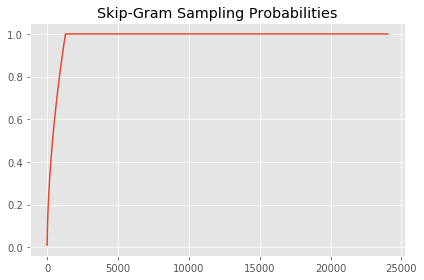

In [27]:
pd.Series(sampling_table).plot(title='Skip-Gram Sampling Probabilities')
plt.tight_layout();

### Generate target-context word pairs

In [28]:
pairs, labels = skipgrams(sequence=data,
                            vocabulary_size=vocab_size,
                            window_size=WINDOW_SIZE,
                            sampling_table=sampling_table,
                            negative_samples=1.0,
                            shuffle=True)

print('{:,d} pairs created'.format(len(pairs)))

35,689,830 pairs created


In [29]:
pairs[:5]

[[122, 99], [1226, 6944], [6529, 8063], [666, 23363], [19601, 20119]]

In [30]:
target_word, context_word = np.array(pairs, dtype=np.int32).T
labels = np.array(labels, dtype=np.int8)
del pairs

In [31]:
target_word[:5]

array([  122,  1226,  6529,   666, 19601], dtype=int32)

In [32]:
df = pd.DataFrame({'target': target_word[:5], 'context': context_word[:5], 'label': labels[:5]})
df

,context,label,target
0,99,1,122
1,6944,0,1226
2,8063,0,6529
3,23363,0,666
4,20119,0,19601


In [33]:
pd.Series(labels).value_counts()

1    17844915
0    17844915
dtype: int64

In [34]:
with pd.HDFStore(path / 'data.h5') as store:
    store.put('id_to_token', pd.Series(id_to_token))

### Define Keras Model Components

#### Scalar Input Variables

In [35]:
input_target = Input((1,), name='target_input')
input_context = Input((1,), name='context_input')

#### Shared Embedding Layer

In [36]:
embedding = Embedding(input_dim=vocab_size,
                      output_dim=EMBEDDING_SIZE,
                      input_length=1,
                      name='embedding_layer')

In [37]:
target = embedding(input_target)
target = Reshape((EMBEDDING_SIZE, 1), name='target_embedding')(target)

context = embedding(input_context)
context = Reshape((EMBEDDING_SIZE, 1), name='context_embedding')(context)

#### Create Similarity Measure

In [38]:
dot_product = Dot(axes=1)([target, context])
dot_product = Reshape((1,), name='similarity')(dot_product)

#### Sigmoid Output Layer

In [39]:
output = Dense(units=1, activation='sigmoid', name='output')(dot_product)

#### Compile Training Model

In [40]:
model = Model(inputs=[input_target, input_context], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')

#### Display Architecture

In [41]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 200)       4807600     target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 200, 1)       0           embedding_layer[0][0]            
__________

#### Validation Model

In [42]:
similarity = Dot(normalize=True, 
                 axes=1, 
                 name='cosine_similarity')([target, context])

In [43]:
# create a secondary validation model to run our similarity checks during training
validation_model = Model(inputs=[input_target, input_context], outputs=similarity)

In [44]:
validation_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
target_input (InputLayer)       (None, 1)            0                                            
__________________________________________________________________________________________________
context_input (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_layer (Embedding)     (None, 1, 200)       4807600     target_input[0][0]               
                                                                 context_input[0][0]              
__________________________________________________________________________________________________
target_embedding (Reshape)      (None, 200, 1)       0           embedding_layer[0][0]            
__________

![Keras Graph](https://s3.amazonaws.com/applied-ai/images/keras_graph_tensorboard.png)

### Create Keras Callbacks

####  Nearest Neighors & Analogies

In [45]:
test_set = analogies_id.dropna().astype(int)
a, b, c, actual = test_set.values.T
actual = actual.reshape(-1, 1)
n_analogies = len(actual)

In [46]:
class EvalCallback(Callback):
        
    def on_train_begin(self, logs={}):
        self.eval_nn()
        self.test_analogies()

    def on_train_end(self, logs={}):
        self.eval_nn()

    def on_epoch_end(self, batch, logs={}):
        self.test_analogies()

    @staticmethod
    def test_analogies():
        print('\nAnalogy Accuracy:\n\t', end='')
        embeddings = embedding.get_weights()[0]
        target = embeddings[c] + embeddings[b] - embeddings[a]
        neighbors = np.argsort(cdist(target, embeddings, metric='cosine'))
        match_id = np.argwhere(neighbors == actual)[:, 1]
        print('\n\t'.join(['Top {}: {:.2%}'.format(i, (match_id < i).sum() / n_analogies) for i in [1, 5, 10]]))

    def eval_nn(self):
        print('\n{} Nearest Neighbors:'.format(NN))
        for i in range(VALID_SET):
            valid_id = valid_examples[i]
            valid_word = id_to_token[valid_id]
            similarity = self._get_similiarity(valid_id).reshape(-1)
            nearest = (-similarity).argsort()[1:NN + 1]
            neighbors = [id_to_token[nearest[n]] for n in range(NN)]
            print('{}:\t{}'.format(valid_word, ', '.join(neighbors)))            
        
    @staticmethod
    def _get_similiarity(valid_word_idx):
        target = np.full(shape=vocab_size, fill_value=valid_word_idx)
        context = np.arange(vocab_size)
        return validation_model.predict([target, context])


evaluation = EvalCallback()

#### Tensorboard Callback

In [47]:
tensorboard = TensorBoard(log_dir=str(tb_path),
                          write_graph=True,
                          embeddings_freq=1,
                          embeddings_metadata=str(tb_path / 'meta.tsv'))

### Train Model

In [48]:
loss = model.fit(x=[target_word, context_word],
                 y=labels,
                 shuffle=True,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 callbacks=[evaluation, tensorboard])

model.save(str(path / 'skipgram_model.h5'))


10 Nearest Neighbors:
've:	relaxed, mute, parcel, strolling, loudspeaker, reserve, beginning, envisioned, louisiana, filth
for:	rhyme, typewriter, traced, bir, academically, resembles, shelter, port, kissed, urethra
kind:	infectious_diseases, wire, 1830s, portraits, snaps, cocoon, dominion, decided, blanket, deneb
time:	paleontologist, bed_nets, baldness, definitions, node, leopard, scrolls, berkley, photoshopped, lgbt
'm:	wounds, civil_rights_movement, anomalies, spines, twittering, laggards, algeria, theories, alma, 87
at:	navigate, item, richest, shuffler, schizophrenic, 1879, synaptic, drives, ice_caps, stereotypical
had:	pearls, maintenance, telemedicine, charcoal, elizabeth, shocked, declined, submissive, populations, tilting
put:	amalgam, adulterous, coastal, banjo, maneuver, compartment, kahn, touch, beers, sharper
your:	skylight, andromeda, eats, spits, mannahatta, jp, worthwhile, climax, swallows, drummer
things:	maps, once, bulldozed, unison, vikings, directors, points, boa

## Optimized TensorFlow Model

Compile custom ops using `compile-ops.sh`.

Run from command line.

In [46]:
!ls tensorflow/

compile-ops.sh      word2vec.py         word2vec_ops.so.zip
run_tf.sh           word2vec_ops.so


In [49]:
# %%bash
# python tensorflow/word2vec.py --language=en --source=Ted --file=ngrams_1 --embedding_size=300 --num_neg_samples=20 --starter_lr=.1 --target_lr=.05 --batch_size=10 --min_count=10 --window_size=10

## word2vec using Gensim

### Evaluation

In [9]:
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='total', ['correct', 'incorrect', 'average']].squeeze().tolist()

### Settings

In [15]:
ANALOGIES_PATH = PROJECT_DIR / 'data' / 'analogies' / 'analogies-{}.txt'.format(LANGUAGE)
gensim_path = PROJECT_DIR / 'gensim' / SOURCE / LANGUAGE / FILE_NAME
if not gensim_path.exists():
    gensim_path.mkdir(parents=True, exist_ok=True)

### Sentence Generator

In [19]:
# sentence_path = PROJECT_DIR / 'vocab' / SOURCE / LANGUAGE / '{}.txt'.format(FILE_NAME)
sentences = LineSentence(docs.tokens)

NameError: name 'docs' is not defined

### Model

In [27]:
start = time()

model = Word2Vec(sentences,
                 sg=1,
                 size=300,
                 window=5,
                 min_count=10,
                 negative=10,
                 workers=8,
                 iter=20,
                 alpha=0.05)

model.wv.save(str(gensim_path / 'word_vectors.bin'))
print('Duration: {:,.1f}s'.format(time() - start))

# gensim computes accuracy based on source text files
detailed_accuracy = model.wv.accuracy(str(ANALOGIES_PATH), case_insensitive=True)

# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

Duration: 266.9s
                       category  correct  incorrect  average
4                        family      128        144     0.47
9      gram5-present-participle      174        756     0.19
7             gram3-comparative      159       1101     0.13
8             gram4-superlative       57        495     0.10
14                        total      824       7700     0.10
12                 gram8-plural       87        843     0.09
11             gram7-past-tense      119       1363     0.08
13           gram9-plural-verbs       45        605     0.07
6                gram2-opposite       12        294     0.04
0      capital-common-countries        7        175     0.04
2                 city-in-state       17        429     0.04
1                 capital-world        3         87     0.03
10  gram6-nationality-adjective       10        746     0.01
5     gram1-adjective-to-adverb        6        644     0.01
3                      currency        0         18     0.00
Base Ac

In [28]:
most_sim = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=10)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,lear,0.27
1,her,0.27
2,mother,0.27
3,she,0.26
4,lg,0.26
5,nurse,0.26
6,ace,0.26
7,zoe,0.26
8,queen,0.25
9,girl,0.24


In [31]:
similars = pd.DataFrame()
for id in valid_examples:
    word = id_to_token[id]
    similars[word] = [s[0] for s in model.wv.most_similar(id_to_token[id])]
    
similars.T

,0,1,2,3,4,5,6,7,8,9
've,have,’ve,got,been,'d,had,has,'re,wandered,unknowns
for,and,of,in,to,that,is,so,at,with,or
kind,sort,kinds,manipulative,trite,urgency,type,bit,a,sense,capricious
time,moment,and,haas,outlaw,dusk,night,swine_flu,year,way,dm
'm,am,i,'re,’m,was,skeptic,want,optimist,going,perplexed
at,in,the,rory,fiddler,from,and,mater,on,for,look
had,have,was,has,'d,got,'ve,could,would,were,61
put,putting,puts,strap,take,go,squeeze,zoom,punched,bring,taped
your,my,you,their,our,her,yourself,his,the,its,can
things,ways,thing,milestones,modes,places,something,projects,kinds,beetles,that


#### Continue Training

In [60]:
accuracies = [summary]
for i in range(1, 11):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.accuracy(str(ANALOGIES_PATH))
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print('{} | Duration: {:,.1f} | Accuracy: {:.2%} '.format(i, time() - start, accuracies[-1][-1]))

pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average']).to_csv(gensim_path / 'accuracies.csv', index=False)
model.wv.save(str(gensim_path / 'word_vectors_final.bin'))

1 | Duration: 30.1 | Accuracy: 9.87% 
2 | Duration: 29.7 | Accuracy: 10.50% 
3 | Duration: 32.2 | Accuracy: 10.28% 
4 | Duration: 32.0 | Accuracy: 10.10% 
5 | Duration: 31.4 | Accuracy: 10.57% 
6 | Duration: 29.9 | Accuracy: 9.89% 
7 | Duration: 30.0 | Accuracy: 10.85% 
8 | Duration: 30.7 | Accuracy: 11.05% 
9 | Duration: 29.5 | Accuracy: 10.71% 
10 | Duration: 29.4 | Accuracy: 11.27% 


## The `google` command-line Tool

### Run from Command Line

In [ ]:
%%bash
file_name=../data/wiki/en/wiki.txt
time ./word2vec -train "$file_name" -output vectors_en.bin - cbow 1 -size 300  -min-count 10  -window 10 -negative 10 -hs 0 -sample 1e-4 -threads 8 -binary 1 -iter 1

### Load Trained Model & Word Vectors via `gensim`

In [32]:
file_name = 'word2vec/word_vectors/vectors_en.bin'
model = KeyedVectors.load_word2vec_format(file_name, binary=True, unicode_errors='ignore')

In [33]:
vectors = model.vectors[:100000]
vectors /= norm(vectors, axis=1).reshape(-1, 1)
vectors.shape

(100000, 300)

In [34]:
words = model.index2word[:100000]
word2id = {w:i for i, w in enumerate(words)}

### Compute Accuracy

In [37]:
analogy_path = PROJECT_DIR / 'data/analogies/analogies-en.txt'
accuracy = model.accuracy(questions=str(analogy_path), restrict_vocab=100000)

In [38]:
summary = accuracy_by_category(accuracy, detail=True)
print('\nOverall Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      459         47     0.91
7             gram3-comparative     1207        125     0.91
10  gram6-nationality-adjective     1472        168     0.90
4                        family      438         68     0.87
1                 capital-world     7058       1132     0.86
12                 gram8-plural     1082        250     0.81
14                        total    17974       6458     0.74
11             gram7-past-tense     1118        442     0.72
9      gram5-present-participle      726        330     0.69
13           gram9-plural-verbs      580        290     0.67
2                 city-in-state     2601       1641     0.61
8             gram4-superlative      605        387     0.61
6                gram2-opposite      254        502     0.34
5     gram1-adjective-to-adverb      312        680     0.31
3                      currency       62        396     0.14

Overall Accuracy: Corre

### Project Data using `tensorboard` Projector

In [66]:
PROJECTION_LIMIT = 10000
proj_path = Path('word2vec', 'projector')
pd.Series(words).iloc[:PROJECTION_LIMIT].to_csv(proj_path / 'meta_data.tsv', index=False, header=None, sep='\t')
pd.DataFrame(vectors).iloc[:PROJECTION_LIMIT].to_csv(proj_path / 'embeddings.tsv', index=False, header=None, sep='\t')

### Project Analogies

#### Incremental PCA

In [35]:
pca = IncrementalPCA(n_components=2)

vectors2D = pca.fit_transform(vectors)
pd.Series(pca.explained_variance_ratio_).mul(100)

0   3.69
1   3.19
dtype: float64

#### Group Analogies by Category

In [39]:
results = pd.DataFrame()
correct = incorrect = 0
for section in accuracy:
    correct += len(section['correct'])
    incorrect += len(section['incorrect'])
    df = pd.DataFrame(section['correct']).apply(lambda x: x.str.lower()).assign(section=section['section'])
    results = pd.concat([results, df])

#### Identify Analogy most similar in 2D

In [41]:
def find_most_similar_analogy(v):
    """Find analogy that most similar in 2D"""
    v1 = vectors2D[v[1]] - vectors2D[v[0]]
    v2 = vectors2D[v[3]] - vectors2D[v[2]]
    idx, most_similar = None, np.inf
    
    for i in range(len(v1)):
        similarity = cosine(v1[i], v2[i])
        if similarity < most_similar:
            idx = i
            most_similar = similarity
    return idx

In [42]:
def get_plot_lims(coordinates):
    xlim, ylim = coordinates.agg(['min', 'max']).T.values
    xrange, yrange = (xlim[1] - xlim[0]) * .1, (ylim[1] - ylim[0]) * .1
    xlim[0], xlim[1] = xlim[0] - xrange, xlim[1] + xrange
    ylim[0], ylim[1] = ylim[0] - yrange, ylim[1] + yrange
    return xlim, ylim

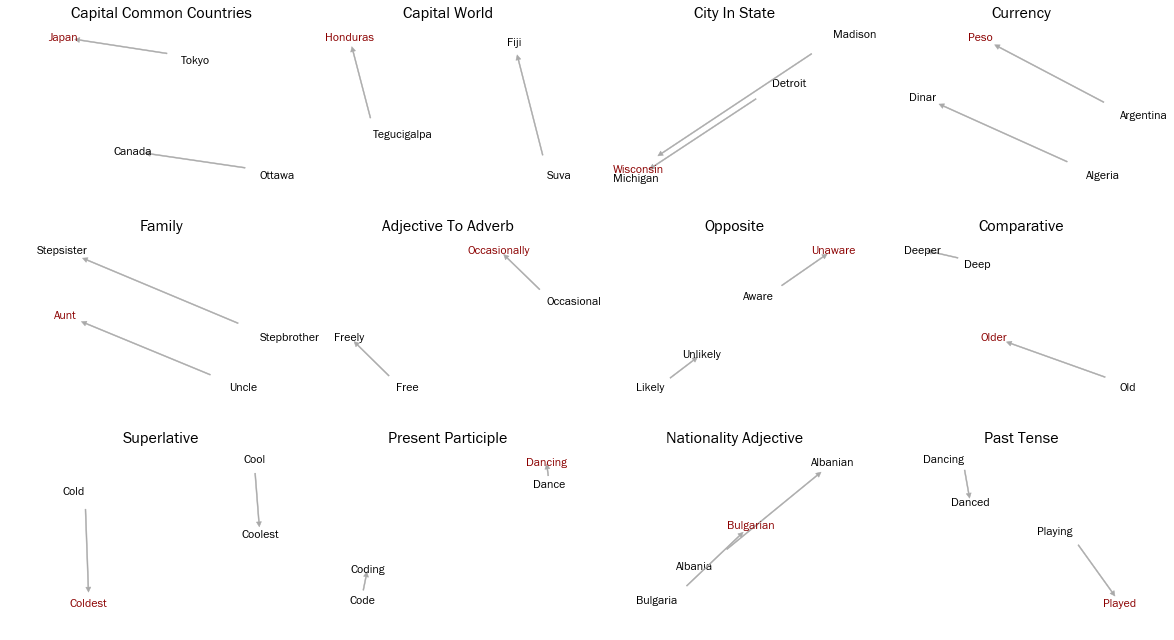

In [43]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 9))
axes = axes.flatten()
fc = ec = 'darkgrey'
for s, (section, result) in enumerate(results.groupby('section')):
    if s > 11:
        continue
        
    df = result.drop('section', axis=1).apply(lambda x: x.map(word2id))
    most_similar_idx = find_most_similar_analogy(df)
    
    best_analogy = result.iloc[most_similar_idx, :4].tolist()

    analogy_idx = [words.index(word) for word in best_analogy]
    best_analogy = [a.capitalize() for a in best_analogy]
    
    coords = pd.DataFrame(vectors2D[analogy_idx])  # xy array
    
    xlim, ylim = get_plot_lims(coords)
    axes[s].set_xlim(xlim)
    axes[s].set_ylim(ylim)

    for i in [0, 2]:
        axes[s].annotate(s=best_analogy[i], xy=coords.iloc[i+1], xytext=coords.iloc[i],
                         arrowprops=dict(width=1,headwidth=5, headlength=5,
                                         fc=fc, ec=ec, shrink=.1),
                         fontsize=12)
    
        axes[s].annotate(best_analogy[i+1], xy=coords.iloc[i+1],
                         xytext=coords.iloc[i+1],
                         va='center', ha='center',
                         fontsize=12, color='darkred' if i == 2 else 'k');

    axes[s].axis('off')
    title = ' '.join([s.capitalize()
                      for s in section.split('-') if not s.startswith('gram')])
    axes[s].set_title(title, fontsize=16)

fig.tight_layout();

## Resources

- [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf?)
- [Sebastian Ruder's Blog](http://ruder.io/word-embeddings-1/)